# Set up analysis environment

In [2]:
using Pkg
Pkg.activate("..");

 Activating environment at `~/code/algorithmwatch-instagram/Project.toml`


In [3]:
Pkg.instantiate()
using CSV, JSON
using DataFrames
using Dates, CategoricalArrays
using Statistics, GLM
using VegaLite

# Load posts and donations
Towards a Monitoring of Instagram (TAMI) is a controlled experiment that aims at shedding light on how items are prioritized by Instagram’s newsfeed algorithm, focusing on political parties in the Netherlands. Posts of Dutch politicians (all members of parliament and the top politician of each party) and political parties were monitored. A set of donors was recruited. Donors share their Instagram feed at hourly intervals. **We are interested in understanding what posts of the politians are encountered by the donors in their feed.**  

We organize the analysis around potential encounters of posts of monitored politicians by donors at hourly intervals. Only the first 7 days after post creation are considered. For each of potential encounter, we store the following dynamic properties at hourly intervals: the number of likes, the number of comments, and the presence of an encounter. We use information from posts to model the probability of an encounter given a certain post. To this end, we prepare a representation of posts with  static properties that can explain the probability of an encounter. It is based on results from the Google Vision API (safe search, label annotations), hashtags from the post text, and the number of followers of the politician’s account.

### Data last updated Feb 5

## Posts

In [4]:
posts = CSV.File("../data/posts_with_topics.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

print("Total posts in the sample (incl. video posts)")
length(unique(posts[!, :post_short_code]))

Total posts in the sample (incl. video posts)

8603

In [5]:
transform!(posts, :poster_username => categorical => :poster_username)
transform!(posts, [:image_adult, :image_medical, :image_racy, :image_spoof, :image_violence] .=> categorical);

For some posts we can't analyze the caption (i.e. it is empty), and sometimes we cannot analyze the image tags (e.g. for videos). These are removed from the analysis:

In [6]:
@show count(ismissing.(posts.ig_media_caption));

transform!(posts, :image_labels => ByRow(x -> length(JSON.parse(x))) => :num_image_labels);
@show count(posts.num_image_labels .== 0);

dropmissing!(posts);
posts = posts[posts.post_created .>= DateTime(2020, 1, 1),:];

print("Total posts in the sample (excl. video posts)")
length(unique(posts[!, :post_short_code]))

count(ismissing.(posts.ig_media_caption)) = 206
count(posts.num_image_labels .== 0) = 1711
Total posts in the sample (excl. video posts)

6716

Now we show the number of posts created by the politicians over time. There could be a ramp-up towards the elections, but many elements need to be considered. In particular: 
- we added new accounts of politicians in November 2020
- our scraper might have missed some posts (might be the cause of the October drop)
- some politicians switched their profiles to "private" over the course of the experiment.

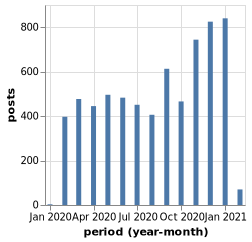

In [7]:
period_posts = combine(
    groupby(transform(unique(posts[!, [:post_short_code, :post_created]]), :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:period]),
    nrow => :num_posts)

period_posts |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"sum(num_posts)", axis={title="posts"}},
)

## Topics

In order to find out whether Instagram's algorithm favored some content over the rest, we divided the posts into topics.

**Topics are defined automatically and change with new data**. We use a latent Dirichlet allocation (LDA) to divide the posts into topics. LDA is a commonly-used algorithm that detects topics in documents based on the distribution of words, and allocates a "topic score" to each, so that a document does not have to be linked to just one topic (e.g. a post showing a face and a cat could be classified as 50% topic "faces" and 50% topic "pets").

We divide all posts into twice 8 topics (the number 8 was chosen arbitrarily), first by caption, then by image labels.

### Caption topics

The words in the topics were organized into eight topics. A label was constructed for each topic by interpreting the top words in each topic. Here are posts that score high on an individual caption topic:

In [8]:
gdf = groupby(stack(posts, names(posts, r"cap_top\d+")), :variable);

Based on these posts, and the top words in `topics_caption.csv` the following interpretion was made. In the figure that show the proportion of the topics over time, we can see that the election topics grows in the lasts months:

In [9]:
topics_caption = CSV.File("../data/topics_caption.csv")|> DataFrame
first(topics_caption,10)

,top1,top2,top3,top4,top5,top6,top7,top8
,String,String,String,String,String,String,String,String
1,fvd,nederland,via,corona,and,even,of,mijn
2,meer,meer,uur,weer,of,nederland,ons,jaar
3,nederland,mensen,link,veel,to,mijn,dan,was
4,geen,worden,live,mensen,i,mooi,jij,nog
5,kabinet,moet,bio,kamer,for,jaar,wil,ze
6,nu,door,kortelijnmetmartijn,zorg,this,weer,nog,door
7,door,wij,vanavond,zo,you,door,bio,heb
8,ons,moeten,zee,alle,piratenpartij,oranje,link,me
9,corona,kunnen,gast,tweede,love,amsterdam,hebben,groenlinks


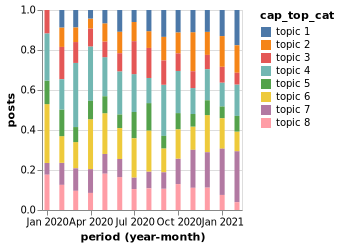

In [10]:
posts.cap_top_cat = recode(string.(posts.cap_top_cat),
    "1" => "topic 1",
    "2" => "topic 2",
    "3" => "topic 3",
    "4" => "topic 4",
    "5" => "topic 5",
    "6" => "topic 6",
    "7" => "topic 7",
    "8" => "topic 8",
);

period_caption = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :cap_top_cat]),
    nrow => :count)

period_caption |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"cap_top_cat:n"})

### Image topics
Images were analyzed with the Google Vision API, and the resulting image tags were organized into eight topics. The post the highest score per topic are listed below:

In [11]:
gdf = groupby(stack(posts, names(posts, r"im_top\d+")), :variable);
#select(
#    combine(df -> first(sort(df, :value, rev=true), 3), gdf),
#    :im_top_cat, :post_short_code => ByRow(x -> string("http://instagram.com/p/", x)))

Based on these posts, and the top labels in `topics_image.csv` the following interpretation of the image topics was made. Some categories are not very clear and some concepts (such as electronics) can easily move from one topic to another when we re-run the LDA topic modelling.

In [12]:
topics_image = CSV.File("../data/topics_image.csv")|> DataFrame
first(topics_image,10)

,top1,top2,top3,top4,top5,top6,top7,top8
,String,String,String,String,String,String,String,String
1,font,architecture,event,event,art,food,face,sky
2,text,building,job,photography,illustration,vehicle,forehead,tree
3,line,interior design,white-collar worker,fun,publication,cuisine,head,plant
4,advertising,room,businessperson,outerwear,font,dish,chin,cloud
5,brand,furniture,employment,smile,photography,car,smile,grass
6,screenshot,table,public speaking,people,black-and-white,ingredient,hair,natural landscape
7,photo caption,city,conversation,tourism,visual arts,motor vehicle,nose,water
8,graphics,house,suit,suit,design,transport,facial expression,natural environment
9,document,sky,spokesperson,team,hand,mode of transport,photography,nature


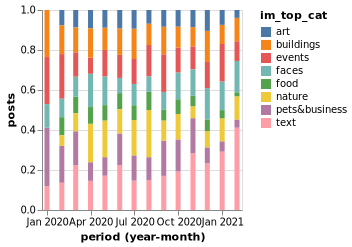

In [13]:
posts.im_top_cat = recode(string.(posts.im_top_cat), 
    "1" => "text",
    "2" => "buildings",
    "3" => "pets&business",
    "4" => "events",
    "5" => "art",
    "6" => "food",
    "7" => "faces",
    "8" => "nature",
);

period_image = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :im_top_cat]),
    nrow => :count)

period_image |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"im_top_cat:n"})

## Donations

Next we load the donations, and display the number of donations over time. The number of donations varied wildly, with a peak in November when the call-to-action was issued.

In [14]:
donations = CSV.File("../data/donations.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

donations.post_DOW = categorical(map(Dates.dayname, donations.post_created), levels=Dates.dayname.(1:7));
donations.post_HOD = categorical(map(x -> Dates.value(Dates.Hour(x)), donations.post_created));
donations.post_age = (donations.donation_created - donations.post_created) / convert(Dates.Millisecond, Dates.Hour(1));

donations.likes_cat = cut(donations.likes_count, [0, 5, 10, 100, 1000], extend=true);
donations.comments_cat = cut(donations.comments_count, 5);
donations.post_age_cat = cut(donations.post_age, [1, 3, 24], extend=true);

@show(nrow(donations))

nrow(donations) = 36930


36930

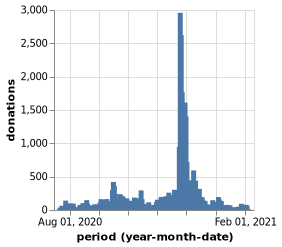

In [15]:
period_donations = combine(
    groupby(transform(donations, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), :period),
    nrow => :num_donations)

period_donations |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonthdate"}, 
    y={"sum(num_donations)", axis={title="donations"}},
)

In [16]:
df = innerjoin(select(donations, Not(:post_created)), posts, on=:post_id);

## RQ1: What posts are overrepresented in the encounters?

To answer this question, we need to describe what posts of Dutch politicians on Instagram are overrepresented in general. This might be due to popularity of the post, or due to biases in Instagram’s recommendations. We are interested in topics, derived from words in the caption and from Google Vision API labels for the post’s images.

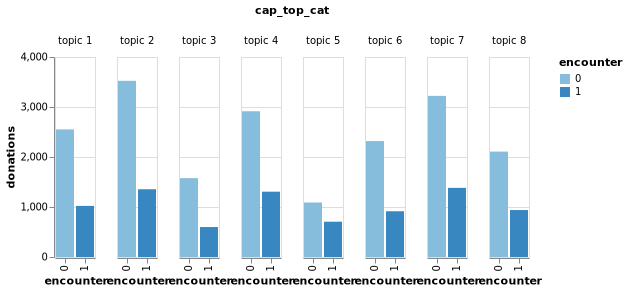

In [17]:
combine(groupby(df, [:cap_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "cap_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = "donations"
)

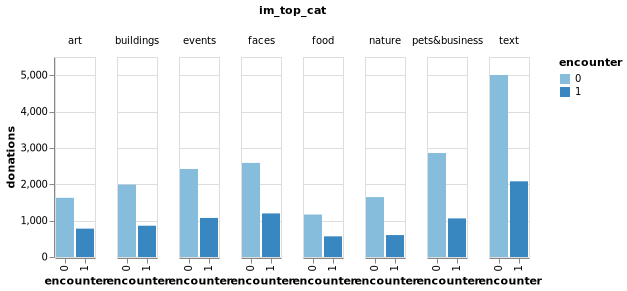

In [18]:
combine(groupby(df, [:im_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "im_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = :donations
)

## RQ2: What posts are overrepresented given their popularity? 
Since overrepresentation is likely to driven by popularity, we analyse what types of posts are overrepresented if we **correct for effects of post popularity** and the timing of a post (time of the day and day of the week). Remaining variations in post popularity can indicate biases in Instagram’s recommendations. The biases might be limited to the population of donors.

In [19]:
baseline_formula = @formula(encounter ~ 1 
    + log1p(post_age) + log1p(likes_count) + log1p(comments_count) + log1p(follows)
    + post_age_cat + likes_cat + comments_cat
    + post_DOW + post_HOD
    );
baseline_model = glm(baseline_formula, df, Binomial(), LogitLink());
df.pred_popularity = predict(baseline_model, df);

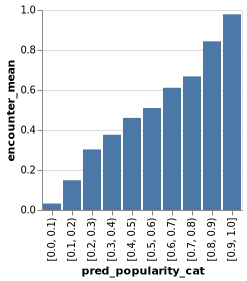

In [20]:
df.pred_popularity_cat = cut(df.pred_popularity, 0:.1:1, extend=true);
combine(groupby(df, :pred_popularity_cat), :encounter=>mean) |> 
    @vlplot(:bar, x="pred_popularity_cat:o", y=:encounter_mean)

This figure shows the encounter frequency is well predicted with the logisitic regression model for popularity. Thus, a large part of the observed encounters can be explained by the presence of competing posts (i.e. time of day or day of week effects), and by the popularity of a post in relation to its age (through post age, likes and comments). We use this model as a popularity factor, to analyse how much properties of the post content *additionally* changes the probability of encountering a post.

In [21]:
odds(p) = p / (1-p);
logit(p) = log(odds(p));

f2 = @formula(
    encounter ~ 1
        + logit(pred_popularity) # Here we re-use the prediction from the popularity model.
        + (im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8)
        + (cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8)
        + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical
    );

m2 = glm(f2, df, Binomial(), LogitLink());
df.prediction_RQ2 = predict(m2, df);

Now we can compare the predictions of the baseline popularity model, and the model that uses topic information in addition to the popularity factors. Differences between the predictions are due to topics. If a topic results in an increased chance of an encouter, we call this a positive bias. To compute the bias, we convert the predictions of both models to log-odds using the logit transform, and compute the difference.

In [22]:
df.bias = logit.(df.prediction_RQ2) - logit.(df.pred_popularity);

Now we can analyze the bias per caption topic.

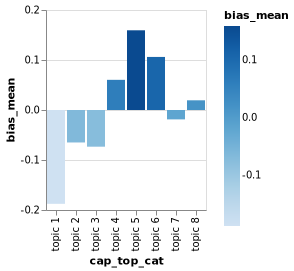

In [23]:
combine(groupby(df, :cap_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="cap_top_cat:o", y=:bias_mean, color=:bias_mean)

Images with the topics `faces` are more likely to reach the donor's feed, while `text` are less likely to reach the donor's feed.

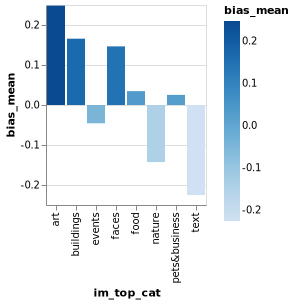

In [24]:
combine(groupby(df, :im_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="im_top_cat:o", y=:bias_mean, color=:bias_mean)

 Note that this bias might not generalize to other content creators than Dutch politicians, and might not generalize to other users than the donors that participated in this experiment.

## RQ3: Is the overrepresentation the same in all subgroups? 

Do the results hold robustly in sub groups? If so, they are more likely to generalize to a wider population. Here we split the data in months, and analyze if the bias is indeed higher for encountered posts than non-encountered posts in each month.

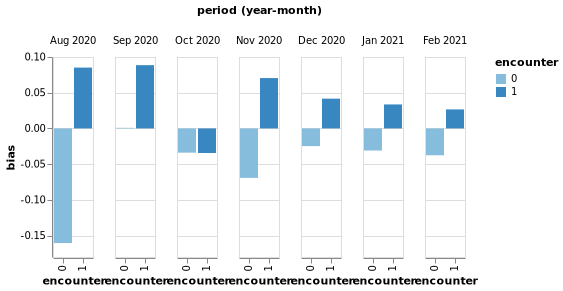

In [25]:
period_bias = combine(
    groupby(transform(df, :post_created => ByRow(t -> round(t, Dates.Month)) => :period), [:period, :encounter]),
    :bias => mean)

period_bias |> @vlplot(:bar, 
    column={"period:o", timeUnit="yearmonth"}, 
    x = "encounter:o",
    y = {"bias_mean", axis={title="bias"}},
    color = "encounter:o",
)

Within each month, a lower bias is observed for non-encounters than encounters. Thus the bias is robust over different months. Note though that the bias varies strongly from month to month. Since the bias is a function of caption and image topics, this suggests that the *content* has changed from month to month.

## RQ4: Who benefit from these discrepancies? 

Finally, we can estimate per politician how much their posts were benefitting from a consistent algorithm bias of Instagram’s recommendations. Note that this bias can be caused by personalisation; if the donors are of a particular political affiliation they might be presented more with content in line with their views.

In [26]:
parties = CSV.File("../data/parties.csv") |> DataFrame;
rename!(parties, Symbol("IG username") => :ig_username, Symbol("Full name") => :name);
parties = dropmissing(parties[!,[:party, :ig_username, :name]]);
parties.ig_username = categorical(parties.ig_username);
parties.party = categorical(parties.party);

In [27]:
post_bias = combine(groupby(df, [:post_id, :poster_username]), :bias => mean => :bias)
post_bias = innerjoin(post_bias, parties, on=:poster_username => :ig_username)

poster_bias = combine(groupby(post_bias, [:poster_username, :party]), 
    nrow => :num_encounterable_posts, 
    :bias .=> mean)

poster_bias.benefit = poster_bias.bias_mean;
poster_bias = sort(poster_bias, :benefit, rev=true)
first(poster_bias[poster_bias.num_encounterable_posts .> 5,:], 5)

,poster_username,party,num_encounterable_posts,bias_mean,benefit
,Cat…,Cat…,Int64,Float64,Float64
1,klaasdijkhoff,VVD,6,0.315399,0.315399
2,cdavandaag,CDA,6,0.196818,0.196818
3,judith_tielen,VVD,22,0.180161,0.180161
4,koerhuisdaniel,VVD,8,0.167648,0.167648
5,michelrogcda,CDA,18,0.15987,0.15987


# Appendix

#### Image topic 1

![](topic1.jpg)

#### Image topic 2

![](topic2.jpg)

#### Image topic 3

![](topic3.jpg)

#### Image topic 4

![](topic4.jpg)

#### Image topic 5

![](topic5.jpg)

#### Image topic 6

![](topic6.jpg)

#### Image topic 7

![](topic7.jpg)

#### Image topic 8

![](topic8.jpg)

#### Caption topic 1

In [28]:
first(select(unique(sort(posts, :cap_top1, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,thierry_baudet,Dit bericht komt zojuist binnen. Onbegrijpelijk.
2,remcovvd,"Sinds 12 maart weer terug in de #TweedeKamer, #vragenuur.."
3,thierry_baudet,We gaan het HELE LAND door met onze 1 miljoen #FVD kranten! #FVDKRANT
4,geertwilders,Rutte: geen handen schudden!\n\n#sukkel
5,geertwilders,"Ons land, onze cultuur, onze identiteit. Nederland is ons land!"
6,geertwilders,Merci #KLM !!
7,suzannekroger_gl,Zo dan maar. #treinleven #OV #corona
8,suzannekroger_gl,Interview in #Corona tijd over klimaateisen aan de #KLM. 📷 @kasberenschot
9,matthijssienot,"Schone energie vraagt om grote investeringen. Corona verkleint de financiële speelruimte van bedrijven.\u202c \u202aD66 wil bedrijven de zekerheid geven dat groene keuzes blijven lonen.\u202c \u202aVideogesprek met VNCI, de branchevereniging voor de chemische industrie, over #groeneruitdecrisis \u202c"


#### Caption topic 3

In [29]:
first(select(unique(sort(posts, :cap_top3, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,#maandagochtend #mood #louvre
2,thierry_baudet,We gaan richting TOTAL NPO INDEPENDENCE!
3,jobavandenberg,Gisteren bij #BNR in #Amsterdam over het #Coronavirus Vandaag in de gele bus 🚌 van #NTR1 in @gemeenteterneuzen samen met #EllendeFeijter @cdazeeland
4,vandijk_gijs,Het is zover. #Lente #Texel
5,klaasdijkhoff,Mijn überprofessionele thuisstudio voor een interview op afstand met Jaïr voor @evajinek
6,remcovvd,In @guggenheim
7,remcovvd,Uitnodiging.. meepraten met de #VVD over #mobiliteit.. 🚗🚚🚄🛵⛴🚴🏼🚆🚝aanmelding via j.verhaaren@tweedekamer.nl
8,verabergkamp,#berenjacht #beervoorhetraam #funforkids #tuurlijk
9,haykeveldman,Den Haag vandaag


#### Caption topic 4

In [30]:
first(select(unique(sort(posts, :cap_top4, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,Onder de indruk van de verhalen en het goede werk van @maximamedischcentrum ! Dank voor jullie inzet! ❤️
2,thierry_baudet,"We stijgen keihard door! Dank aan alle volgers, dank voor alle support! Ik doe het voor jullie. En mét jullie! En dankzij jullie!"
3,bentebecker,"Vanochtend ben ik voor heel even juf van groep 7😊Als dank aan alle onderwijstoppers die hun lessen op afstand zo goed verzorgen, is er dit initiatief van @onlinegastles. Mijn les gaat over “hoe hou je een goede spreekbeurt.” Hoop dat ik het er zelf een beetje goed vanaf breng:) tot straks kinderen!! #OnlineGastles"
4,sandra_beckerman,Niet alle entiteiten waarderen de extra aandacht die ze krijgen door het thuiswerken
5,adiertens,Voor de briefing van het RIVM. Stil en alleen op onze gang.
6,klaasdijkhoff,Hallmark speelt open kaart...
7,remcovvd,#Thuiswerken is ook bellen vanuit de tuin en dan loop je rondjes.. #covid_19 #corona
8,remcovvd,Doen. Wees verstandig! #corona
9,niels_vdberge,Vandaag in het wit voor alle helden in de zorg.👨\u200d⚕️👩🏾\u200d⚕️👩🏼\u200d⚕️👨🏽\u200d⚕️ #ikdraagwitvoordezorg #wereldgezondheidsdag #coronacrisis


#### Caption topic 5

In [31]:
first(select(unique(sort(posts, :cap_top5, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,mustafaamhaouch,🏃🏽\u200d♂️🇲🇦 #sportyspice
2,thierry_baudet,"The last supper. Scrovegni Chapel, Padua (Giotto). I’ll never forget when I visited this sacred place with my father. So beautiful. Blessed easter to all of you!"
3,thierry_baudet,#friends #love
4,thierry_baudet,Prachtfoto!\n\nCredits: @lonneke_stulen.
5,klaasdijkhoff,Bij de mondkapper... Thanks @markosuds @suds_hairdressing \n#kooplokaal \n#raarjaar
6,klaasdijkhoff,#Applausvoordezorg 👏🏼
7,remcovvd,Kip met knoflook on the #bbq 🔥#chicken with #garlic #food
8,remcovvd,Een #Hercules #plane #spotting #planespotting #keepussafe #blueskies
9,remcovvd,How to make your puber #child #happy? #sushi #cooking #sushitime #food #foodporn 🍴 🍤🥗 🍣


#### Caption topic 6

In [32]:
first(select(unique(sort(posts, :cap_top6, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,thierry_baudet,Mijn lieve papa! @baudetmarcel
2,thierry_baudet,Lente. Thuis.
3,sandra_beckerman,Ook even tijd voor de cruciale beroeper aka de geliefde @bart.vermeulen.12
4,salimabelhaj,Avondje kaarten thuis. Met wel heel bijzondere kaarten van Little #feminist playing cards. #Kleinmomentjevanplezier.
5,jobavandenberg,Even naar buiten voor korte wandeling 🥾Door nieuwe spoortunnel 🚅 in @gemeentegoes en langs hertenkamp met pauw 🦚 die met zijn veren pronkt
6,remcovvd,En een burgertje op de #bbq 🍔 wat een mooie zomerse dag! 💛🏖☀️
7,remcovvd,Rondje Batouwse klompenpad #walking #betuwe @lienden #lienden
8,remcovvd,Paardjes kijken #rondje #wandelen @blijfthuis #Betuwe
9,remcovvd,"Klompenpad gewandeld, vlakbij huis.. #betuwe #batouwe #lienden #tollewaard #marspolder #rivierenland 11,6km"


#### Caption topic 7

In [33]:
first(select(unique(sort(posts, :cap_top7, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,Interview in AD (link in bio): laat marktdenken los en zorg dat overheid weer naast mensen gaat staan. Daarom ook samenwerken met @groenlinks en @sp En over de komende verkiezingen natuurlijk.
2,thierry_baudet,BINNENKORT!
3,carla_dik_faber,Heb je hulp nodig? Je bent #Nietalleen! Wil je helpen? Je bent #Nietalleen!\nGa naar www.nietalleen.nl of bel 0800-1322.
4,tjeerdvand66,Netjes in overhemd in beeld maar....wel in korte broek 😆
5,thechangeagent,Nieuwe schoenen! En nieuwe blog. Link in bio!
6,thechangeagent,Weten hoe dit experiment afliep? Lees mijn nieuwste blog (link in bio) 😅\n#coronacoupe
7,johnwmkerstens,"Ok. Het is misschien niet zo verfijnd, maar het is wel duidelijk. #dochtermeteenmening"
8,johnwmkerstens,Sunbeams.
9,johnwmkerstens,Post van een kiezer.


#### Caption topic 8

In [34]:
first(select(unique(sort(posts, :cap_top8, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,lodewijkasscher,"Vandaag herdenken we. Ik denk aan dit vrolijke baby’tje: het kind dat gered werd. Ik denk aan de mensen die hem redden. De moed die zij hadden, de onbeschrijflijke moed. De veiligste plek om hem te verstoppen was als hun kind, hun zoon. In hun gezin. Ik denk aan het verdriet - toen en erna. En ben dankbaar. Omdat dit kind gered werd, leven wij nu nog. Preciezer, leef ik nu."
2,lodewijkasscher,@kinderburgemeester.ilias interviewde me tijdens de #onderwijsstaking- een grote eer voor mij
3,jobavandenberg,In herinnering mijn ouders die deze week 65 jaar getrouwd zouden zijn geweest.
4,zohair_30,"Tijdens de herdenking van 4 mei 2017 was ik aanwezig op het Nationaal Ereveld in Loenen. Terwijl ik langzaam over het bospad liep op weg mijn eer te betonen aan hen die slachtoffer werden tijdens de oorlog, viel mijn oog op deze laatste rustplaats. \u202a\n\nHet graf van Gerrit Azuerus Zeeman, die in 1945 het leven had gelaten op 36-jarige leeftijd. Op drie maanden na, dezelfde leeftijd als ik had in 2017 toen ik anderhalve maand eerder geïnstalleerd werd als Tweede Kamerlid. Op dat moment waren we dus eigenlijk leeftijdsgenoten. \u202a\n\nGerrit Zeeman is gestorven op 7 januari. Dat is ook nog eens de sterfdag van mijn vader in 2017. Mijn vader, die echt vrij leefde en altijd zijn eigen keuzes kon maken.\n\nDeze laatste rustplaats van Gerrit Zeeman op het Nationaal Ereveld in Loenen maakt mij weer eens duidelijk hoe belangrijk en kwetsbaar 75 jaar vrijheid is. En dat we er elke dag voor moeten blijven knokken. \nIk herdenk en sta stil bij #75jaarvrijheid"
5,niels_vdberge,"5 mei 2018, Wageningen👇🏽Mooie herinnering. Heel gek om #75jaarvrijheid in relatieve onvrijheid te vieren. \u202c \u202aNiet in Wageningen, zonder studievrienden.\u202c \u202aMaar gelukkig kan het wel: de vrijheid thuis vieren. Laten we dat doen. Omdat het niet vanzelfsprekend is. #bevrijdingsdag\u202c #nooitvergeten"
6,verabergkamp,#idahot Belangrijk dat iedereen zichtbaar zichzelf kan zijn!
7,verabergkamp,‘Politiek is te belangrijk om aan mannen over te laten’ (Els Borst) #vrouwendag
8,verabergkamp,‘Het zijn de kleine dingen die het doen.’😃
9,eppobruins,Stoere dame.


#### Caption topic 1

In [35]:
first(select(unique(sort(posts, :cap_top1, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

,poster_username,ig_media_caption
,Cat…,String
1,thierry_baudet,Dit bericht komt zojuist binnen. Onbegrijpelijk.
2,remcovvd,"Sinds 12 maart weer terug in de #TweedeKamer, #vragenuur.."
3,thierry_baudet,We gaan het HELE LAND door met onze 1 miljoen #FVD kranten! #FVDKRANT
4,geertwilders,Rutte: geen handen schudden!\n\n#sukkel
5,geertwilders,"Ons land, onze cultuur, onze identiteit. Nederland is ons land!"
6,geertwilders,Merci #KLM !!
7,suzannekroger_gl,Zo dan maar. #treinleven #OV #corona
8,suzannekroger_gl,Interview in #Corona tijd over klimaateisen aan de #KLM. 📷 @kasberenschot
9,matthijssienot,"Schone energie vraagt om grote investeringen. Corona verkleint de financiële speelruimte van bedrijven.\u202c \u202aD66 wil bedrijven de zekerheid geven dat groene keuzes blijven lonen.\u202c \u202aVideogesprek met VNCI, de branchevereniging voor de chemische industrie, over #groeneruitdecrisis \u202c"


In [36]:
m2

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(logit(pred_popularity)) + im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8 + cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8 + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────
                                    Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                    -0.269738    0.0738701  -3.65    0.0003   -0.41452    -0.124955
logit(pred_popularity)          1.01247     0.0131414  77.04    <1

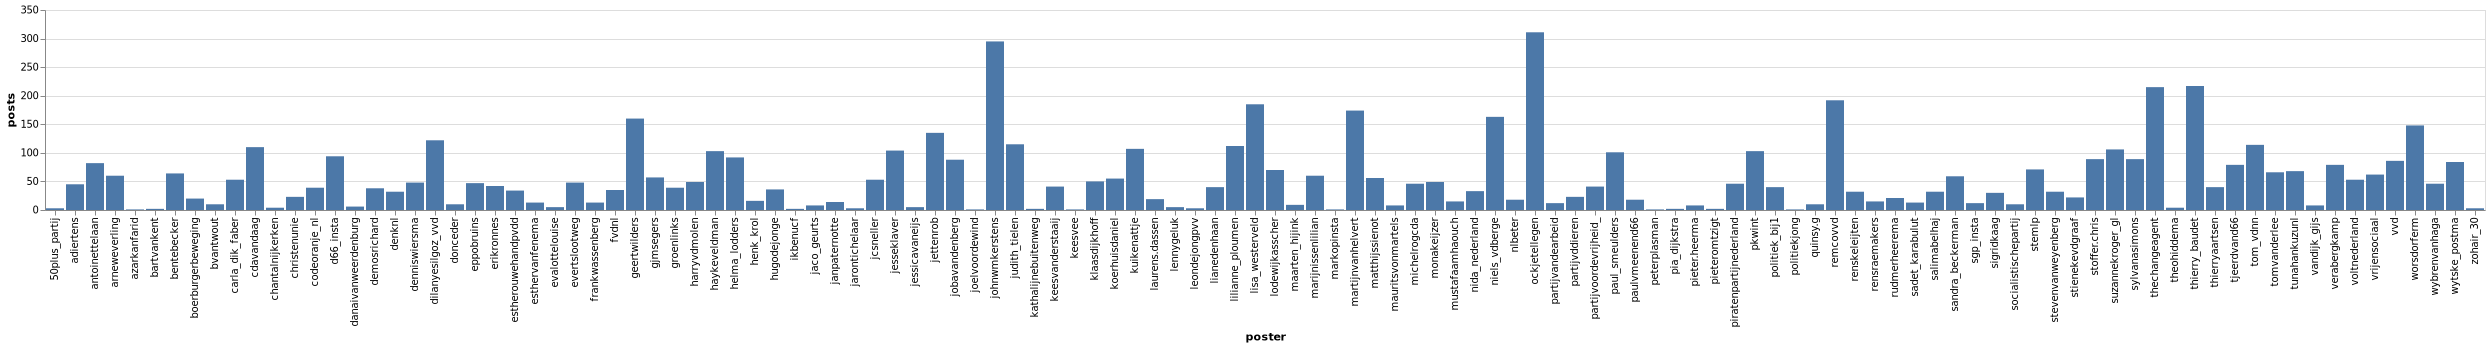

In [37]:
period_posts = combine(
    groupby(transform(posts, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:poster_username, :period]),
    nrow => :num_posts)

sort!(period_posts, [:poster_username])

period_posts |> @vlplot(
    :bar,
    x={"poster_username:o", sort="x", axis={title="poster"}},
    y={"sum(num_posts)", axis={title="posts"}}
)